# Résultats des analyses sur Annonceur1_campagne3_visite_2pages

Nous présentons ici les résultats graphiques et leur analyse pour la campagne mentionnée.

In [1]:
#fichiers contenant les fonctions utiles
import pandas as pd
from premiere_analyse import preparer, analyser, transformer, explorer
from testZ import testZ, proportions, testZ_cum
import matplotlib.pyplot as plt
import statsmodels.tsa.api as smt
import statsmodels.api as sm

import numpy as np
import scipy.stats as st
import seaborn as sns
sns.set_style("white")

%load_ext autoreload
%autoreload 2

/anaconda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
#données de la campagne
# folder = 'C:/Users/Admin/Documents/Centrale Paris/3A/OMA/Projet/Donnees/'
folder = 'Data/'
annonceur = 'annonceur1/annonceur1'
campagne = 'annonceur1_campaign3_visite_2pages'
data = pd.read_hdf(folder + annonceur + '.hdf', key=campagne)

Analyse du taux de conversion des versions A et B de la bannière en tant que série temporelle

In [3]:
#préparation des données
dataA, dataB = preparer(data) 

Conversion des index en dates
Moyennes des taux par jour et séparation en deux groupes A et B


La moyenne du taux de conversion pour les 2 groupes est très similaire :

In [4]:
data.groupby('group')['is_conv'].mean()

group
A    0.000096
B    0.000093
Name: is_conv, dtype: float64

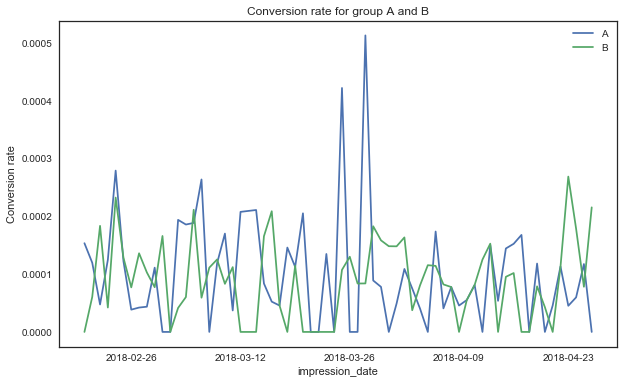

In [5]:
plt.figure(figsize=(10, 6))
dataA['is_conv'].plot(label='A')
dataB['is_conv'].plot(label='B')
plt.legend()
plt.title('Conversion rate for group A and B')
plt.ylabel("Conversion rate")
plt.show()

# Groupe A

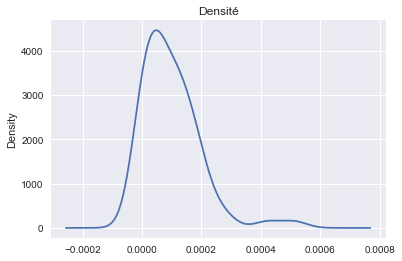

## Analyse classique d'une ST

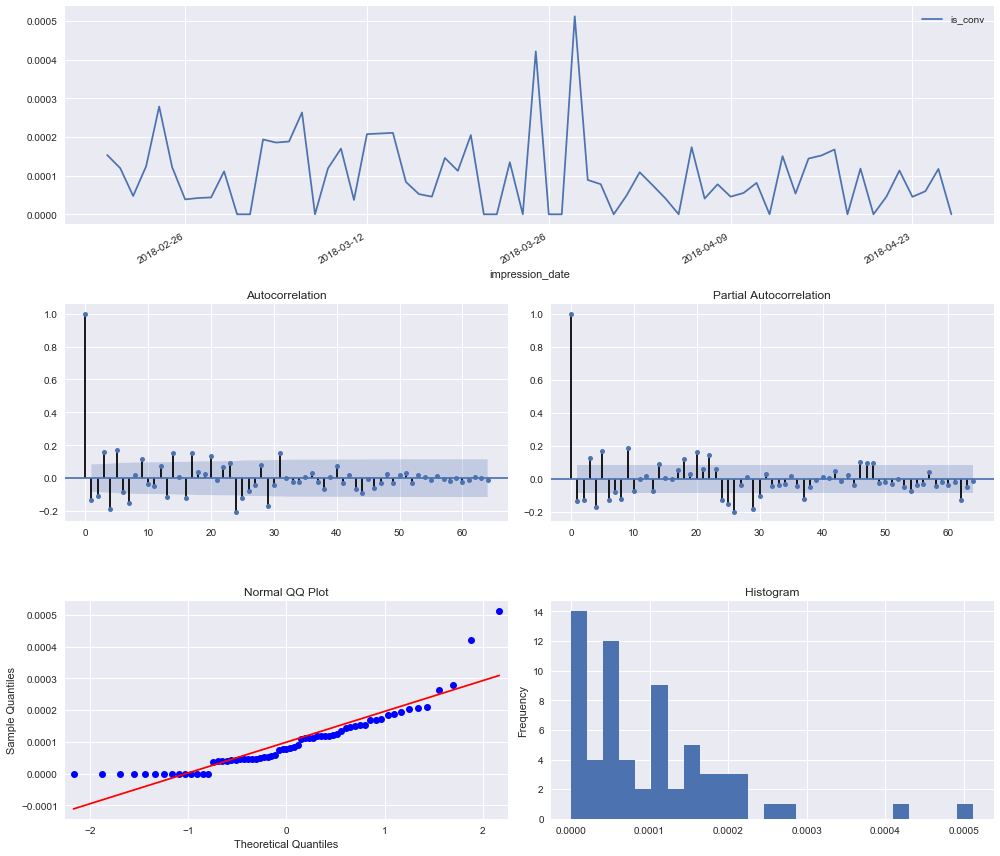

## Effet journalier

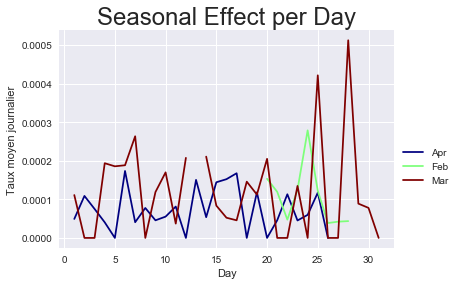

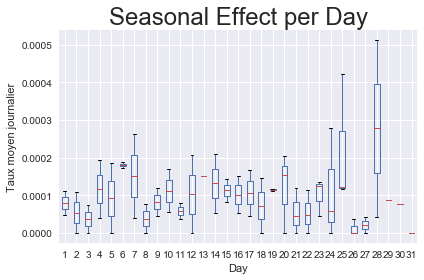

## Décomposition de la série de temps selon modèle multiplicatif



Multiplicative seasonality is not appropriate for zero and negative values


## Test de Dickey-Fuller

,Results of Augmented Dickey-Fuller test:
test statistic,-8.966872e+00
p-value,7.945456e-15
# of lags,0.000000e+00
# of observations,6.400000e+01
Critical Value (1%),-3.536928e+00
Critical Value (5%),-2.907887e+00
Critical Value (10%),-2.591493e+00


In [4]:
#Analyse temporelle du taux de conversion A
analyser(dataA)

Analyse des résultats obtenus:
- Test de Dickey-Fuller indique que la série est stationnaire car la statistique de test est moins élevée que la valeur critique à 1%. 

Différencier à l'ordre 1: y_t - y_[t-1]
Analyse après transformation



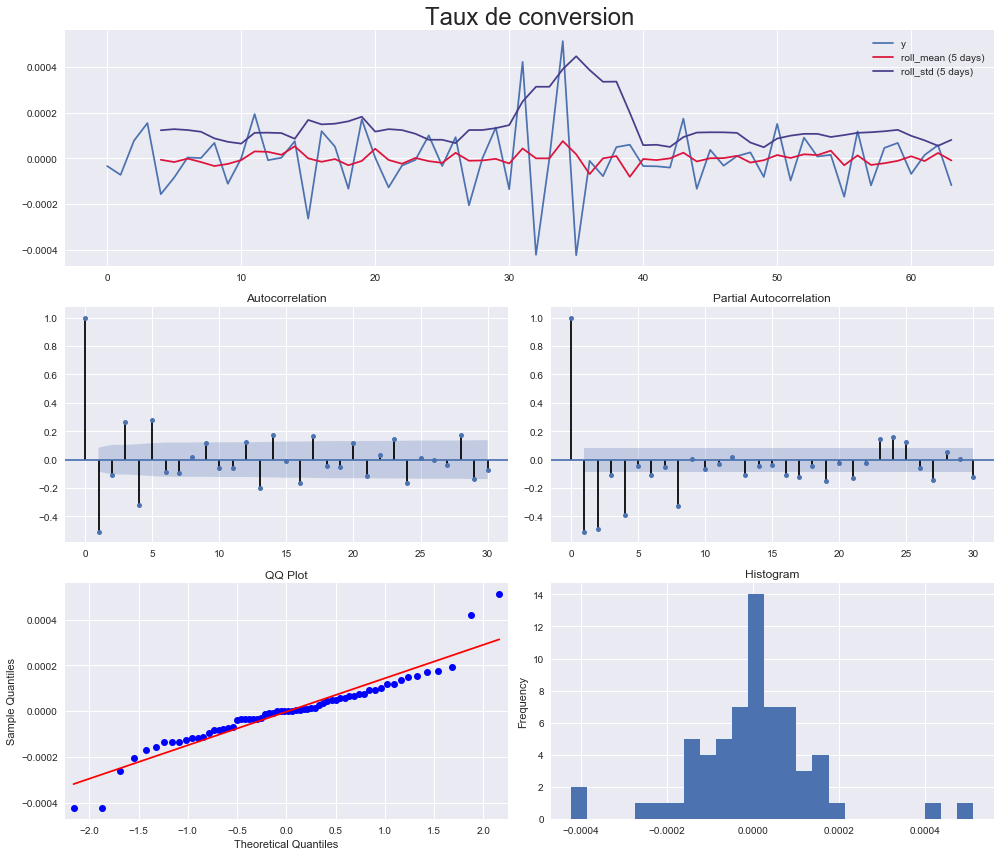

,Results of Augmented Dickey-Fuller test:
test statistic,-7.740512e+00
p-value,1.065030e-11
# of lags,3.000000e+00
# of observations,6.000000e+01
Critical Value (1%),-3.544369e+00
Critical Value (5%),-2.911073e+00
Critical Value (10%),-2.593190e+00


In [5]:
transformer(dataA,"diff1")

Après différenciation, la série est stationnaire aussi d'après le test de Dickey-Fuller.

# Groupe B

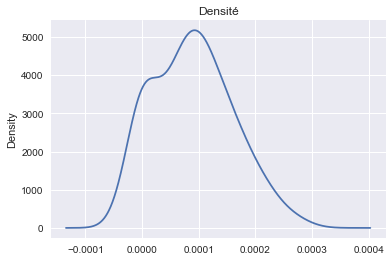

## Analyse classique d'une ST

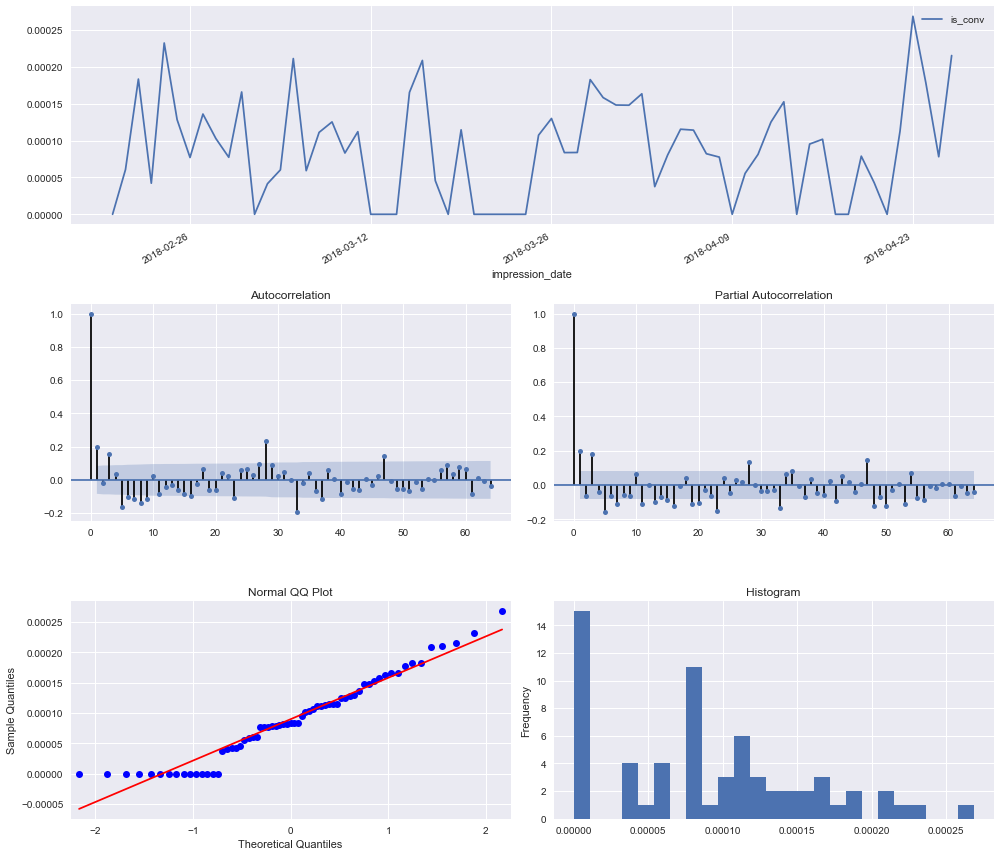

## Effet journalier

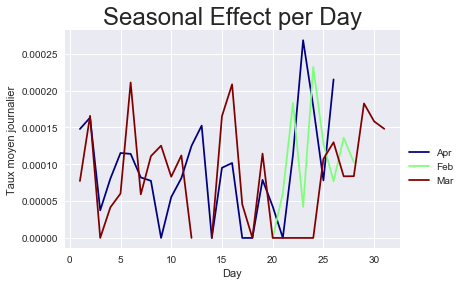

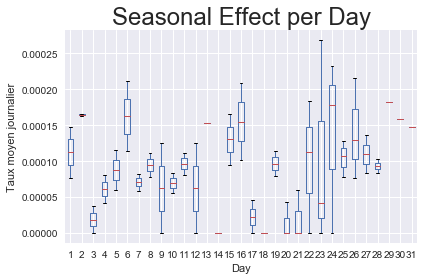

## Décomposition de la série de temps selon modèle multiplicatif



Multiplicative seasonality is not appropriate for zero and negative values


## Test de Dickey-Fuller

,Results of Augmented Dickey-Fuller test:
test statistic,-3.174044
p-value,0.021537
# of lags,4.000000
# of observations,60.000000
Critical Value (1%),-3.544369
Critical Value (5%),-2.911073
Critical Value (10%),-2.593190


In [6]:
#analyse temporelle du taux de conversion B
analyser(dataB)

Analyse des résultats obtenus:
- Test de Dickey-Fuller indique que la série n'est pas stationnaire car la statistique de test est plus élevée que la valeur critique à 1%. On réalise donc une tranformation sur la série pour la rendre stationnaire.

Différencier à l'ordre 1: y_t - y_[t-1]
Analyse après transformation



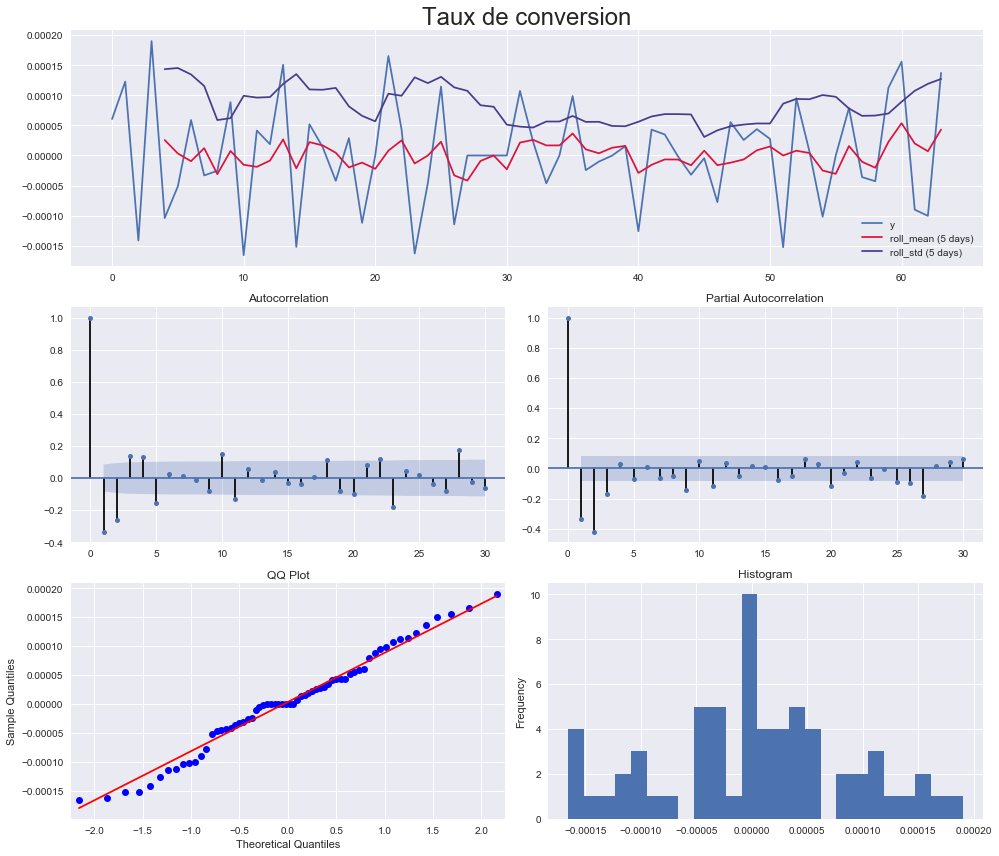

,Results of Augmented Dickey-Fuller test:
test statistic,-7.130671e+00
p-value,3.524617e-10
# of lags,2.000000e+00
# of observations,6.100000e+01
Critical Value (1%),-3.542413e+00
Critical Value (5%),-2.910236e+00
Critical Value (10%),-2.592745e+00


In [7]:
transformer(dataB,"diff1")

Après différenciation, la série est stationnaire d'après le test de Dickey-Fuller.

# Test Z

Enfin, on réalise un test Z sur les données ave H0 "les taux de conversion A et B sont similaires". Le test nous donnera une statistique qui nous permettra de calculer la p-valeur i.e. la probabilité de rejeter l'hypothèse nulle H0.

In [8]:
Z, Prej = testZ(data)
print('Zstat = {0:.3}, Prej={1:.3}'.format(Z, Prej))

Zstat = 0.254, Prej=0.8


On ne peut donc pas rejeter l'hypothèse nulle avec un seuil de confiance classique (5%, 1%): aucune des deux versions n'est meilleure que l'autre en termes de taux de conversion journalier.

Est-ce que le Z-test aurait donné des résultats différents si l'on a arrêté le test A/B à des instants plus tôt ? On réalise un Z-test roulant.

In [3]:
Z_cum, P_rej, p_cum = testZ_cum(data)

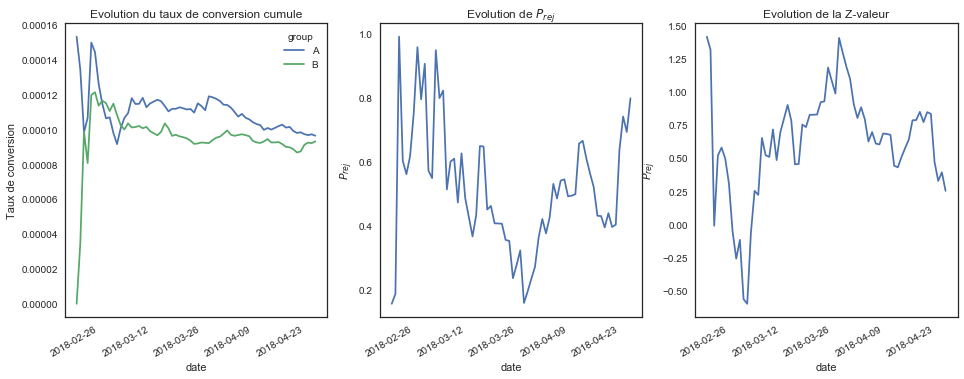

In [4]:
plt.figure(figsize=(16, 6))

plt.subplot(1, 3, 1)
p_cum.plot(title="Evolution du taux de conversion cumule", ax=plt.gca())
plt.ylabel("Taux de conversion")

plt.subplot(1, 3, 2)
P_rej.plot(title='Evolution de $P_{rej}$', ax=plt.gca())
plt.ylabel('$P_{rej}$')

plt.subplot(1, 3, 3)
Z_cum.plot(title='Evolution de la Z-valeur', ax=plt.gca())
plt.ylabel('$P_{rej}$')

plt.show();

In [5]:
P_rej.describe()

count    65.000000
mean      0.520041
std       0.194517
min       0.157267
25%       0.404691
50%       0.495233
75%       0.627800
max       0.992288
Name: P_rej, dtype: float64

In [6]:
Z_cum.describe()

count    65.000000
mean      0.623766
std       0.409175
min      -0.597575
25%       0.455329
50%       0.682010
75%       0.833272
max       1.414322
dtype: float64

Les résultats du Z test sont donc très différents en fonction de l'instant considéré : si on s'était arrêté vers début Mars vs fin Mars.
Il serait peut-être intéressant d'étudier la stationnarité de la série des P_rej ou de la valeur Z.